## Modularity on the Karate Club Graph
This notebook analyzes **community structure** using modularity in NetworkX.

## What we need to do::
- Implement recursive spectral modularity partitioning to detect multiple communities in the Karate Club graph  
- Visualize the graph after each split with different colors for communities  
- Compute node metrics (degree centrality, betweenness centrality, closeness centrality, clustering)  
- Plot how these metrics evolve across iterations  
- Write a short discussion about which nodes remain central and how community structure influences metrics

## We start by importing all the necessary libraries like Numpy, NetworkX and matplotlib.

In [698]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from itertools import chain


Now we will see how this karate club graph looks like which we will just take form the networkx lib.

Graph named "Zachary's Karate Club" with 34 nodes and 78 edges


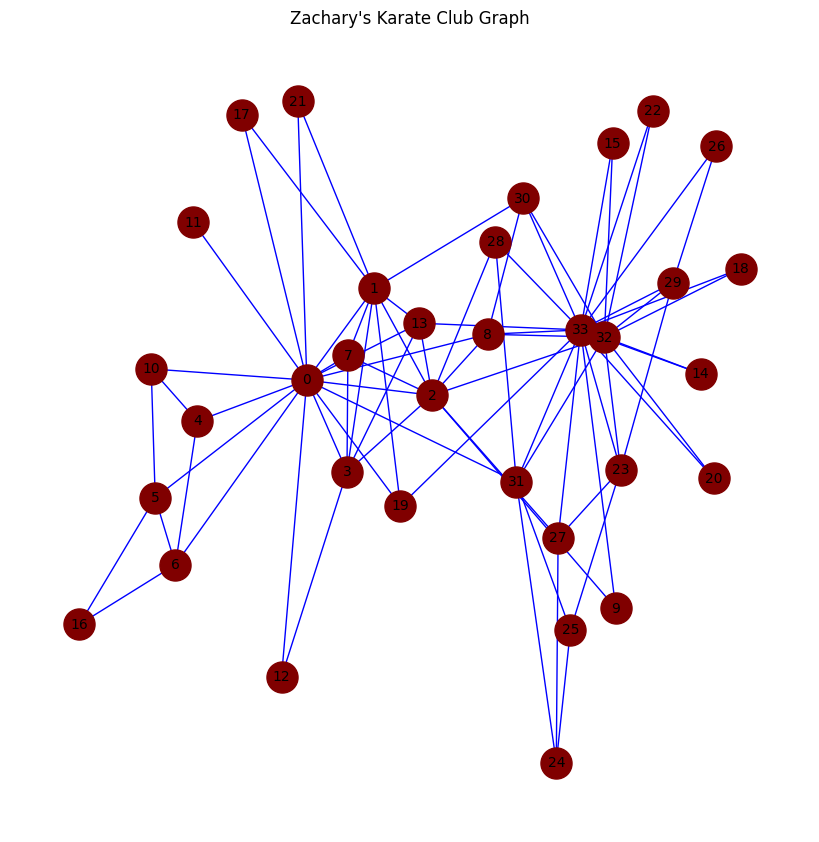

In [699]:
G= nx.karate_club_graph()
print(G)
pos= nx.spring_layout(G,seed=7)
plt.figure(figsize=(8, 8))
nx.draw(G, pos, with_labels=True, node_color="maroon", edge_color="blue", node_size=500, font_size=10)
plt.title("Zachary's Karate Club Graph")
plt.show()


Now we will define the adjacency matrix, A and required things in order to get **modularity matrix(B)**:
$$
\mathbf{B} = \mathbf{A} - \frac{\mathbf{k} \mathbf{k}^\top}{2m},
$$

    where, A = adjacency matrix with n rows and n coulumn.
           k = degree matrix with n rows and 1 column.
           m = no. of edges.

In [700]:
A=nx.to_numpy_array(G)
node_list= list(G.nodes())
n=len(node_list)
k = np.array([G.degree(node) for node in node_list]).reshape(n,1)
# list comprehension to ensure order of nodes is same as in node_list.
m = np.sum(k)/2
print("Adjacency matrix:\n",A)
print("degree matrix:\n",k)
print("Number of Edges: ",m)

Adjacency matrix:
 [[0. 4. 5. ... 2. 0. 0.]
 [4. 0. 6. ... 0. 0. 0.]
 [5. 6. 0. ... 0. 2. 0.]
 ...
 [2. 0. 0. ... 0. 4. 4.]
 [0. 0. 2. ... 4. 0. 5.]
 [0. 0. 0. ... 4. 5. 0.]]
degree matrix:
 [[16]
 [ 9]
 [10]
 [ 6]
 [ 3]
 [ 4]
 [ 4]
 [ 4]
 [ 5]
 [ 2]
 [ 3]
 [ 1]
 [ 2]
 [ 5]
 [ 2]
 [ 2]
 [ 2]
 [ 2]
 [ 2]
 [ 3]
 [ 2]
 [ 2]
 [ 2]
 [ 5]
 [ 3]
 [ 3]
 [ 2]
 [ 4]
 [ 3]
 [ 4]
 [ 4]
 [ 6]
 [12]
 [17]]
Number of Edges:  78.0


Now we have everything to find our Modularity Matrix,B.

In [701]:
B = A - (np.matmul(k,k.T))/(2*m)
print(B)

[[-1.64102564  3.07692308  3.97435897 ...  1.38461538 -1.23076923
  -1.74358974]
 [ 3.07692308 -0.51923077  5.42307692 ... -0.34615385 -0.69230769
  -0.98076923]
 [ 3.97435897  5.42307692 -0.64102564 ... -0.38461538  1.23076923
  -1.08974359]
 ...
 [ 1.38461538 -0.34615385 -0.38461538 ... -0.23076923  3.53846154
   3.34615385]
 [-1.23076923 -0.69230769  1.23076923 ...  3.53846154 -0.92307692
   3.69230769]
 [-1.74358974 -0.98076923 -1.08974359 ...  3.34615385  3.69230769
  -1.8525641 ]]


Since we got our Modularity Matrix, we can now calculate **Modularity Score, Q** which is given by:

$$
Q = \frac{1}{4m} \mathbf{s}^\top \mathbf{B} \mathbf{s}.
$$
    where, Q is a function of s, a label vector which assigns +1 or -1 to all nodes based on the community they belong to.

Here," $\mathbf{s}^\top \mathbf{B} \mathbf{s}$ " measures how well the vertex partition
induced by s (recall that the elements of s are +1 or −1 and induces a partition over the vertex
set) aligns with positive values in B (i.e., pairs that are more connected than chance).

**Large positive Value of Q --> more within-community edges than expected at random.**

So that the entire problem of community detection (in this simplified two-community case) boils down to a single task:

$$
\textit{Choose the components of } \mathbf{s} \in \{-1, +1\}^n \textit{ so that } 
Q = \frac{1}{4m}\, \mathbf{s}^\top \mathbf{B}\, \mathbf{s} \textit{ is maximized.}
$$

So what we have to do now is to find the Vector **s** that maximizes Q.
But since s ∈ {−1, +1}, maximizing over all {−1, +1}
n vectors means checking 2n possible assignments which is impossible even for moderate n. So we use a standard trick in optimization: relax the problem.
Therefore we allow $s_i$ to take any real value but constrain $∥s∥_2$ = 1(which just represent the norm of s.)
Then the problem becomes:
$$
\max_{\|s\|_2 = 1} \; s^\top B s .
$$

A classic result from linear algebra says: **the maximizer of the above maximization problem is the eigenvector of B corresponding to the largest eigenvalue, called the leading eigenvector.**

Now we will calculate EigenValues and EigenVectors of Modularity Matrix from there we will get our Leading EigenValue which is nothing but the largest eigenvalue of Modularity Matrix and it corresponds to Leading EigenVector which is the most useful thing in community detection in Graph.

This is called **Spectral bipartition algorithm.**

In the relaxation, $u_1$ gives us a “soft assignment” of nodes: nodeswith positive entries are pushed toward one side of the split and nodes with negative entries are pushed toward the other. Intuitively:

• If $(u_1)_i$ is strongly positive, node i “wants” to be in community 1.

• If $(u_1)_i$ is strongly negative, node i “wants” to be in community 2.

• If $(u_1)_i$ is close to zero, node i is not strongly tied to either side.

Since we need a hard partition, we simply assign:
$$
s_i =
\begin{cases}
+1 & \text{if } ( \mathbf{u}_1 )_i > 0, \\
-1 & \text{otherwise}.
\end{cases}
$$

This gives us a discrete $\mathbf{s} \in \{-1, +1\}^n ,$, i.e., a proper bipartition of the graph.

In [702]:
def spectral_bisection(B, nodes):
    """Return community split and leading eigenvalue for the given modularity matrix."""
    eigvals, eigvecs = np.linalg.eigh(B)
    idx = np.argsort(eigvals)[::-1]
    leading_eigval = eigvals[idx[0]]
    leading_eigvec = eigvecs[:, idx[0]]

    s = np.sign(leading_eigvec)
    
    group1 = [nodes[i] for i in range(len(nodes)) if s[i] > 0]
    group2 = [nodes[i] for i in range(len(nodes)) if s[i] <= 0]

    return s, group1, group2


nodes = list(G.nodes())
s, group1, group2=spectral_bisection(B, nodes)


			   First Spectral Bipartition of the Karate Club Graph:

Using the modularity matrix 𝐵 and the leading eigenvector of 𝐵, we perform a spectral bisection
of the full Karate Club graph.

Nodes are divided into two communities based on the sign of the eigenvector entries (+ vs −).
The two clusters detected are visualized below with different color.

And this looks exactly how our Karate Club would've been split into two communities.
One following the club president, the other following Mr. Hi.



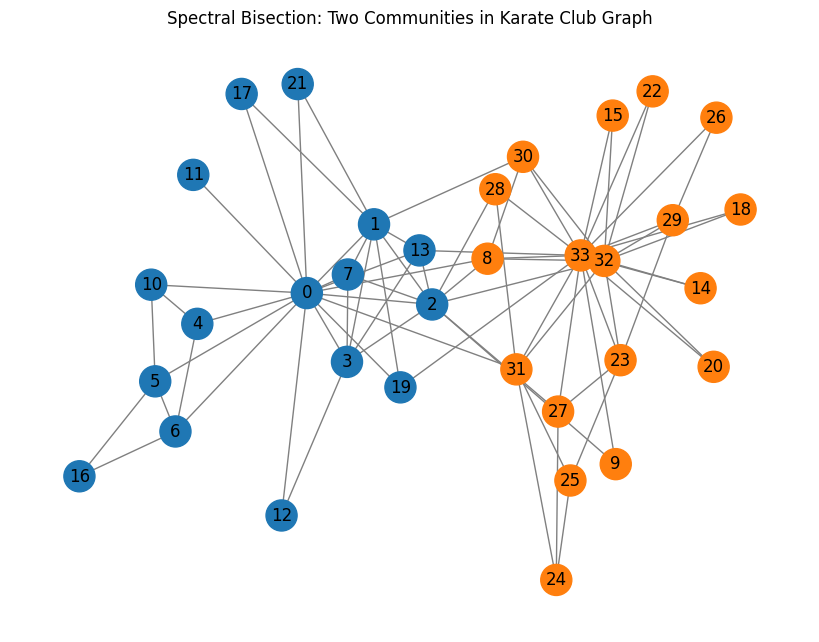

Community 1: [0, 1, 2, 3, 4, 5, 6, 7, 10, 11, 12, 13, 16, 17, 19, 21]
Community 2: [8, 9, 14, 15, 18, 20, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33]


In [703]:
print("\t\t\t   First Spectral Bipartition of the Karate Club Graph:\n")
print("Using the modularity matrix 𝐵 and the leading eigenvector of 𝐵, we perform a spectral bisection\nof the full Karate Club graph.\n")
print("Nodes are divided into two communities based on the sign of the eigenvector entries (+ vs −).\nThe two clusters detected are visualized below with different color.\n")
print("And this looks exactly how our Karate Club would've been split into two communities.\nOne following the club president, the other following Mr. Hi.\n")



colors = []
for n in G.nodes():
    if n in group1:
        colors.append("tab:blue")
    else:
        colors.append("tab:orange")

plt.figure(figsize=(8,6))
nx.draw(G, pos, with_labels=True, node_color=colors, edge_color="gray", node_size=500)
plt.title("Spectral Bisection: Two Communities in Karate Club Graph")
plt.show()

print("Community 1:", group1)
print("Community 2:", group2)


Now we move on to dp **Iterative Algorithm to Detect All Communities** which will be done by:
##                                  Recursive Spectral Modularity Partitioning



In [704]:
def recursive_partition(G, min_size=3):
    communities = []
    stack = [list(G.nodes())]

    while stack:
        nodes = stack.pop()
        subG = G.subgraph(nodes)

    
        eigvals, eigvecs = np.linalg.eigh(B)
        leading_val = eigvals[np.argmax(eigvals)]
        leading_vec = eigvecs[:, np.argmax(eigvals)]
        s = np.sign(leading_vec)
        s[s == 0] = 1

        group1 = [nodes[i] for i in range(len(nodes)) if s[i] > 0]
        group2 = [nodes[i] for i in range(len(nodes)) if s[i] <= 0]

        if leading_val <= 0 or len(group1) == 0 or len(group2) == 0 or len(nodes) <= min_size:
            communities.append(nodes)
        else:
            stack.append(group1)
            stack.append(group2)

    return communities
